### Import

In [1]:
import itertools

import numpy as np

import skfuzzy as fuzz
from skfuzzy import control as ctrl

import matplotlib.pyplot as plt

### Antecedents

In [2]:
demand = ctrl.Antecedent(universe=np.arange(10, 25, 1), label='demand')
supply = ctrl.Antecedent(universe=np.arange(2, 7, 1), label='supply')

In [3]:
demand.universe, supply.universe

(array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
 array([2, 3, 4, 5, 6]))

### Consequents

In [4]:
price_adjustment = ctrl.Consequent(universe=np.linspace(-0.5, 0.5, 21), label='price_adjustment')
# price_adjustment = ctrl.Consequent(universe=np.linspace(-1, 1, 21), label='price_adjustment')


In [5]:
price_adjustment.universe

array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
       -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
        0.4 ,  0.45,  0.5 ])

### Membership

In [6]:
supply.automf(names=['low', 'medium', 'high'])
demand.automf(names=['low', 'medium', 'high'])

In [7]:
# price_adjustment['low'] = fuzz.trimf(price_adjustment.universe, [-0.300, -0.300, 0.075])
# price_adjustment['low_medium'] = fuzz.trimf(price_adjustment.universe, [-0.300, -0.150, 0.000])
# price_adjustment['medium'] = fuzz.trimf(price_adjustment.universe, [-0.150, 0.000, 0.150])
# price_adjustment['medium_high'] = fuzz.trimf(price_adjustment.universe, [0.000, 0.150, 0.300])
# price_adjustment['high'] = fuzz.trimf(price_adjustment.universe, [0.150, 0.300, 0.300])

price_adjustment.automf(names=['low', 'low_medium', 'medium', 'medium_high', 'high'])

/home/rafael_doepfer/d/_Files/GoogleDrive/development/learning/data_science/fuzzy/dynamic_pricing/.venv/lib/python3.14/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


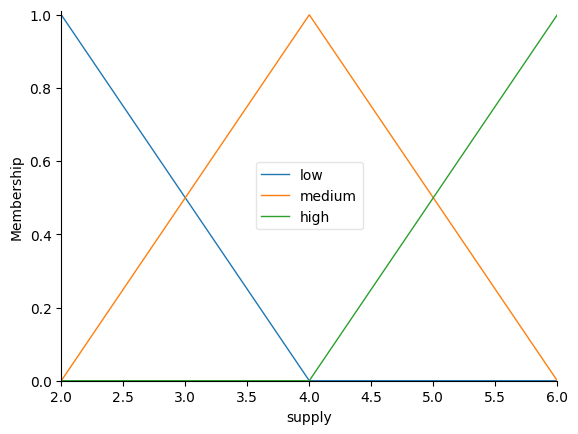

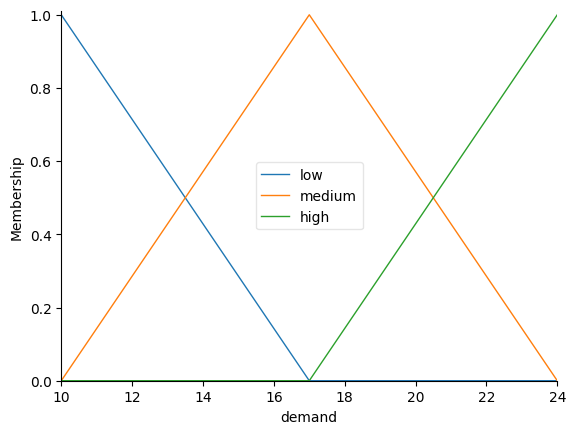

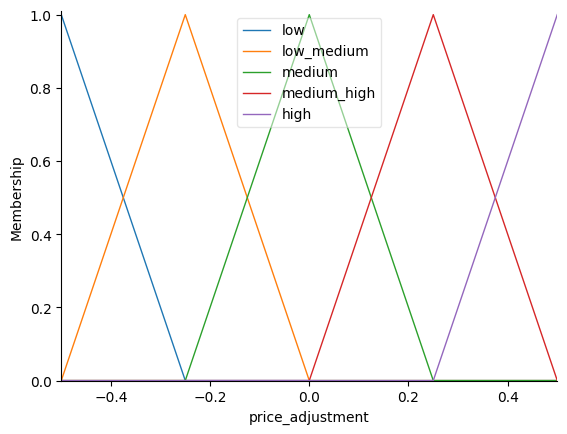

In [8]:
supply.view()
demand.view()
price_adjustment.view()

### Rules

In [9]:
# demand_terms = list(demand.terms.keys())
# demand_terms = ['d_' + term for term in demand_terms]

# supply_terms = list(supply.terms.keys())
# supply_terms = ['s_' + term for term in supply_terms]

# list(itertools.product(demand_terms, supply_terms))

In [10]:
rule1 = ctrl.Rule(demand['low'] & supply['low'], price_adjustment['medium'])
rule2 = ctrl.Rule(demand['low'] & supply['medium'], price_adjustment['low_medium'])
rule3 = ctrl.Rule(demand['low'] & supply['high'], price_adjustment['low'])

rule4 = ctrl.Rule(demand['medium'] & supply['low'], price_adjustment['medium_high'])
rule5 = ctrl.Rule(demand['medium'] & supply['medium'], price_adjustment['medium'])
rule6 = ctrl.Rule(demand['medium'] & supply['high'], price_adjustment['low_medium'])

rule7 = ctrl.Rule(demand['high'] & supply['low'], price_adjustment['high'])
rule8 = ctrl.Rule(demand['high'] & supply['medium'], price_adjustment['medium_high'])
rule9 = ctrl.Rule(demand['high'] & supply['high'], price_adjustment['medium'])

### Control System

In [11]:
price_ctrl = ctrl.ControlSystem(
    [
        rule1, rule2, rule3,
        rule4, rule5, rule6,
        rule7, rule8, rule9,
    ]
)

### Simulation

In [12]:
price_adjust = ctrl.ControlSystemSimulation(price_ctrl)

In [13]:
price_adjust.input['demand'] = 15
price_adjust.input['supply'] = 2

price_adjust.compute()

0.16910388733481233


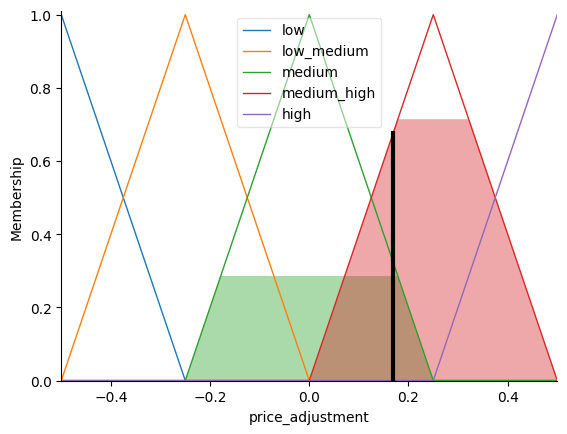

In [14]:
print(price_adjust.output['price_adjustment'])
price_adjustment.view(sim=price_adjust)

### Dynamic pricing

#### Simulations

In [15]:
variations = []
for _ in range(50):
    demand_value = np.random.choice(demand.universe)
    supply_value = np.random.choice(supply.universe)

    price_adjust.input['demand'] = demand_value
    price_adjust.input['supply'] = supply_value

    price_adjust.compute()

    variations.append(price_adjust.output['price_adjustment'])

In [16]:
# figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))

# ax.set_xlim(xmin=0, xmax=len(variations))
# ax.set_ylim(ymin=np.min(price_adjustment.universe) + np.min(price_adjustment.universe) * 0.10, ymax=np.max(price_adjustment.universe) + np.max(price_adjustment.universe) * 0.10)
# ax.plot(variations, marker='o' )

# # for index, value in enumerate(variations):
# #     ax.text(index, value, f'{value}', va='bottom', ha='left')

# ax.grid(True, linestyle='--', alpha=0.9)

# plt.show()

#### Price limit

In [17]:
upper_limit = 1_800
upper_edge = 1_700

lower_edge = 1_300
lower_limit = 1_200

mean = np.mean([upper_limit, lower_limit])

#### Initial price

In [18]:
initial_price = mean

#### Pricing

In [19]:
prices = [initial_price]
current_price = initial_price

for variation in variations:    

    if variation > 0:
        current_price = current_price + (upper_limit - current_price) * variation      

    if variation < 0:
        current_price = current_price + (current_price - lower_limit) * variation


    # round method 1
    ndigits = len(str(current_price * 0.1).split('.')[0]) - 2
    round_price = round(current_price, ndigits=-ndigits)
    round_price = round_price - 0.01

    # print(current_price, round_price, ((round_price - current_price) / current_price) * 100)


    # round method 2
    # magnitude = np.floor(np.log10(current_price))
    # base = 10 ** (magnitude - 2)
    # round_price = np.ceil(current_price / base) * base - 0.01

    # print(current_price, round_price, ((round_price - current_price) / current_price) * 100)


    current_price = round_price
        
    prices.append(current_price)

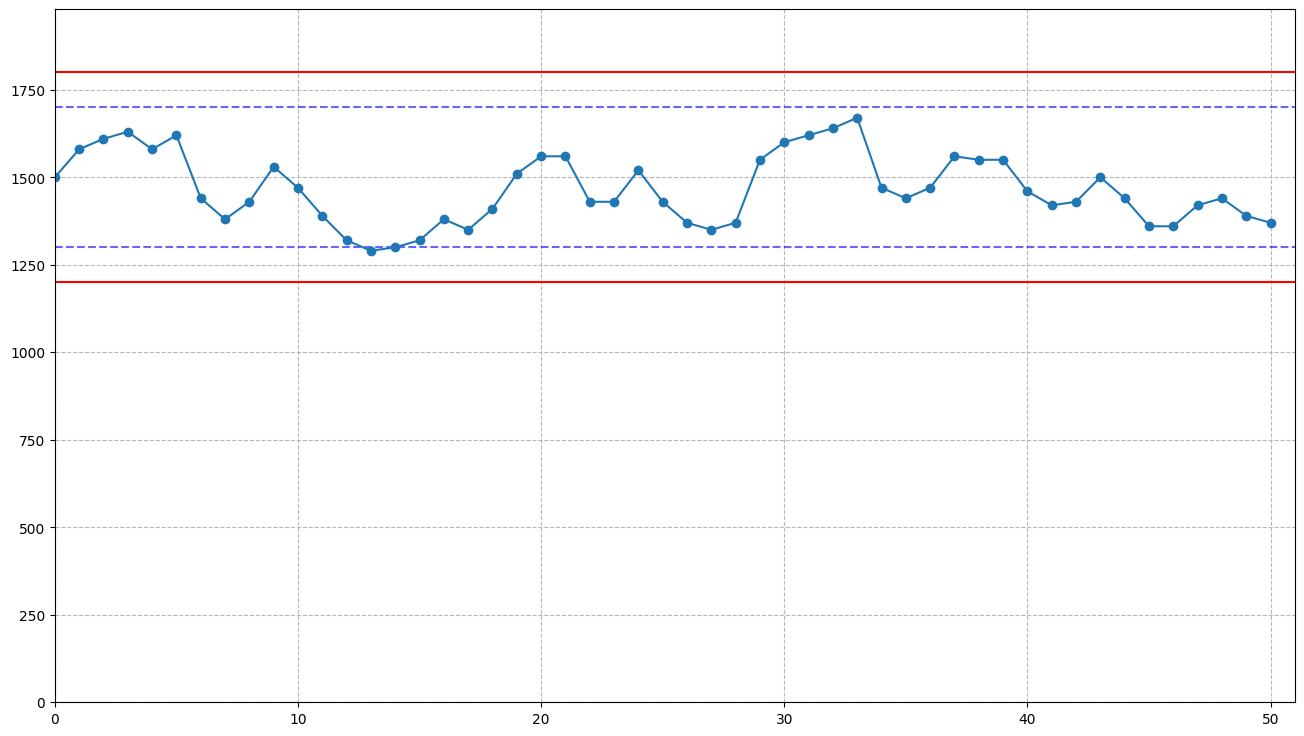

In [20]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
ax.set_xlim(xmin=0, xmax=len(prices))
ax.set_ylim(ymin=0, ymax=upper_limit + upper_limit * 0.10)
ax.axhline(upper_limit, color='r')
ax.axhline(lower_limit, color='r')
ax.axhline(upper_edge, color='b', linestyle='--', alpha=0.6)
ax.axhline(lower_edge, color='b', linestyle='--', alpha=0.6)
ax.plot(prices, marker='o' )

# for index, value in enumerate(prices):
#     ax.text(index, value, f'{value}', va='bottom', ha='left')

ax.grid(True, linestyle='--', alpha=0.9)

plt.show()